In [4]:
from mario_replays.load_data import load_replay_data
import os
import pandas as pd
from mario_scenes.load_data import load_background_images
from mario_scenes.load_data import load_scenes_info

sourcedata = '../../mario_learning.behavior/sourcedata/'

In [5]:
clips_df = load_replay_data(os.path.join(sourcedata, 'scene_clips'), type='metadata')
clips_variables = load_replay_data(os.path.join(sourcedata, 'scene_clips'), type='variables')

repetitions_df = load_replay_data(os.path.join(sourcedata, 'replays'), type='metadata')
repetitions_variables = load_replay_data(os.path.join(sourcedata, 'replays'), type='variables')


In [6]:
import numpy as np
from scipy.interpolate import interp1d

from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt


def get_traces(subject, level, variables_df):
    subj_repvars = variables_df[variables_df['subject'] == subject]
    if len(level)>4:
        subj_repvars['scene'] = [x.split('_')[-2].split('-')[1] for x in subj_repvars['metadata'].values]
        subj_repvars['level'] = [f'{lvl}s{scene}' for lvl, scene in zip(subj_repvars['level'].values, subj_repvars['scene'].values)]
    subset_subj_repvars = subj_repvars[subj_repvars['level'] == level]

    x_list = []
    y_list = []
    order_list = []
    for idx, repvars in subset_subj_repvars.iterrows():
        repvars['player_x_pos'] = [
            hi * 256 + lo for hi, lo in zip(repvars['player_x_posHi'], repvars['player_x_posLo'])
        ]
        pstate = np.asarray(repvars['player_state'])
        y_pos= np.asarray([x+24-(1-repvars['player_y_screen'][idx])*256 for idx, x in enumerate(repvars['player_y_pos'])])
        y_pos_masked = np.ma.masked_where(pstate==0, y_pos)
        y_list.append(list(y_pos_masked))
        if len(level)>4:
            x_list.append([x - repvars['player_x_pos'][0] for x in repvars['player_x_pos']])
        else:
            x_list.append(repvars['player_x_pos'])

        fname = repvars['filename'].split('/')[-1].split('.')[0]
        ses = fname.split('_')[1].split('-')[1]
        rep = fname.split('_')[-1].split('-')[1]
        if len(level)>4:
            order_list.append(int(repvars['metadata'].split('_')[-1].split('-')[1]))
        else:
            order_list.append(int(f'{ses}{rep}'))
    return x_list, y_list, order_list


def draw_traces_on_image(image, x_values_list, y_values_list, order_values, line_size=2, ticks=5):
    """
    Draws traces on an image using ordinal order for coloring, and adds a vertical colormap with tick marks and labels on the left.

    Parameters:
    -----------
    image : PIL.Image
        The image on which to draw.

    x_values_list : list of lists
        A list containing N lists of x-values.

    y_values_list : list of lists
        A list containing N lists of y-values.

    order_values : list
        A list of N values whose ordinal position defines the trace color.

    line_size : int
        Thickness of the lines to be drawn.

    ticks : int
        Number of tick marks and labels on the colormap.

    Returns:
    --------
    PIL.Image
        The new image with traces and a ranked colormap.
    """
    assert len(x_values_list) == len(y_values_list) == len(order_values), "Mismatched input lengths."

    width, height = image.size
    colorbar_width = 20
    label_margin = 35
    margin_ratio = 0.05  # 5% top and bottom margin
    top_margin = int(height * margin_ratio)
    bottom_margin = int(height * margin_ratio)
    colorbar_height = height - top_margin - bottom_margin

    new_img = Image.new("RGB", (width + colorbar_width + label_margin, height), "white")
    new_img.paste(image, (colorbar_width + label_margin, 0))
    draw = ImageDraw.Draw(new_img)

    N = len(order_values)
    colormap = plt.get_cmap('viridis')

    # Compute rank order of traces
    sorted_indices = np.argsort(order_values)
    ranked_orders = [None] * N
    for rank, idx in enumerate(sorted_indices):
        ranked_orders[idx] = rank

    # Normalize to [0, 1] colormap
    norm_orders = np.linspace(0, 1, N)

    # Draw colorbar within vertical bounds
    for i in range(colorbar_height):
        t = 1 - (i / (colorbar_height - 1))
        y = top_margin + i
        color = tuple(int(c * 255) for c in colormap(t)[:3])
        draw.line([(label_margin, y), (label_margin + colorbar_width - 1, y)], fill=color)

    # Draw tick marks and labels on the left
    try:
        font = ImageFont.truetype("arial.ttf", 12)
    except IOError:
        font = ImageFont.load_default()

    for i in range(ticks):
        t = i / (ticks - 1)
        y = top_margin + int(t * (colorbar_height - 1))
        rank = int(round((1 - t) * (N - 1)))
        label = str(rank)

        # Tick mark
        tick_x0 = label_margin - 5
        tick_x1 = label_margin - 1
        draw.line([(tick_x0, y), (tick_x1, y)], fill="black", width=1)

        # Label
        draw.text((2, y - 6), label, fill="black", font=font)

    # Draw traces with rank-based color
    for idx, (x_vals, y_vals) in enumerate(zip(x_values_list, y_values_list)):
        rank = ranked_orders[idx]
        color = tuple(int(c * 255) for c in colormap(norm_orders[rank])[:3])
        points = list(zip(x_vals, y_vals))
        if len(points) < 2:
            continue
        for i in range(len(points) - 1):
            p1 = (x_vals[i] + colorbar_width + label_margin, y_vals[i])
            p2 = (x_vals[i + 1] + colorbar_width + label_margin, y_vals[i + 1])
            draw.line([p1, p2], fill=color, width=line_size)

    return new_img

In [7]:
level_backgrounds = load_background_images(level='level')
x_list, y_list, order_list = get_traces('01', 'w8l2', repetitions_variables)
draw_traces_on_image(level_backgrounds['w8l2'], x_list, y_list, order_list, line_size=1)

/home/hyruuk/mambaforge/envs/mario_learning/lib/python3.10/site-packages/PIL/ImageDraw.py:246: UserWarning: Warning: converting a masked element to nan.
  self.draw.draw_lines(xy, ink, width)


KeyboardInterrupt: 

In [ ]:
## Full levels
for subject in ['01', '02', '03', '05', '06']:
    outputfolder = f'../outputdata/figures/traces/sub-{subject}/levels/'
    os.makedirs(outputfolder, exist_ok=True)
    level_backgrounds = load_background_images(level='level')
    for level in level_backgrounds.keys():
        x_list, y_list, order_list = get_traces(subject, level, repetitions_variables)
        draw_traces_on_image(level_backgrounds[level], x_list, y_list, order_list, line_size=1).save(os.path.join(outputfolder, f'sub-{subject}_level-{level}_traces.png'))

In [ ]:
## Scenes

for subject in ['01', '02', '03', '05', '06']:
    outputfolder = f'../outputdata/figures/traces/sub-{subject}/scenes/'
    os.makedirs(outputfolder, exist_ok=True)
    scene_backgrounds = load_background_images(level='scene')
    for scene in sorted(scene_backgrounds.keys()):
        x_list, y_list, order_list = get_traces(subject, scene, clips_variables)
        draw_traces_on_image(scene_backgrounds[scene], x_list, y_list, order_list, line_size=1).save(os.path.join(outputfolder, f'sub-{subject}_scene-{scene}_traces.png'))


In [43]:
clips_df

,Subject,World,Level,Duration,Cleared,ScoreGained,X_Traveled,Average_speed,Lives_lost,Hits_taken,...,EndFrame,TotalFrames,Bk2File,GameName,LevelFullName,SceneFullName,IndexInRun,IndexGlobal,IndexLevel,Phase
0,01,2,1,4.483333,False,50,82,18.289963,1,1,...,2082,5702,sub-01_ses-001_run-04_level-w2l1_scene-14_clip...,SuperMarioBros-Nes,w2l1,w2l1s14,5,38,5,discovery
1,01,1,2,2.450000,True,0,174,71.020408,0,0,...,1273,3098,sub-01_ses-001_run-02_level-w1l2_scene-0_clip-...,SuperMarioBros-Nes,w1l2,w1l2s0,5,16,5,discovery
2,01,1,2,3.083333,True,10,250,81.081081,0,0,...,1024,3090,sub-01_ses-001_run-02_level-w1l2_scene-1_clip-...,SuperMarioBros-Nes,w1l2,w1l2s1,1,12,1,discovery
3,01,1,3,3.566667,True,0,159,44.579439,0,0,...,1377,2597,sub-01_ses-001_run-03_level-w1l3_scene-5_clip-...,SuperMarioBros-Nes,w1l3,w1l3s5,8,29,8,discovery
4,01,1,3,6.066667,False,0,156,25.714286,1,1,...,2527,2528,sub-01_ses-001_run-03_level-w1l3_scene-6_clip-...,SuperMarioBros-Nes,w1l3,w1l3s6,1,22,1,discovery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56136,06,8,2,0.916667,True,0,135,147.272727,0,0,...,3821,6729,sub-06_ses-025_run-05_level-w8l2_scene-3_clip-...,SuperMarioBros-Nes,w8l2,w8l2s3,2,608,27,practice
56137,06,5,2,14.316667,True,100,190,13.271246,0,0,...,3609,8074,sub-06_ses-025_run-01_level-w5l2_scene-10_clip...,SuperMarioBros-Nes,w5l2,w5l2s10,1,585,30,practice
56138,06,8,2,2.033333,True,0,162,79.672131,0,0,...,842,6729,sub-06_ses-025_run-05_level-w8l2_scene-2_clip-...,SuperMarioBros-Nes,w8l2,w8l2s2,2,608,27,practice
56139,06,5,3,2.416667,True,0,129,53.379310,0,0,...,277,5862,sub-06_ses-025_run-02_level-w5l3_scene-0_clip-...,SuperMarioBros-Nes,w5l3,w5l3s0,2,591,26,practice


In [ ]:
repetitions_df

,Subject,World,Level,Duration,Cleared,ScoreGained,X_Traveled,Average_speed,Lives_lost,Hits_taken,...,Powerups_collected,Bricks_destroyed,CoinsGained,IndexInRun,Run,IndexGlobal,IndexLevel,Phase,LevelFullName,Bk2File
0,01,1,1,40.616667,True,2105,3116,76.717275,0,0,...,0,0,2,3,run-01,3,3,discovery,w1l1,sub-01_ses-001_task-mario_level-w1l1_rep-003
1,01,1,3,58.216667,False,1985,2371,40.727169,2,2,...,0,0,7,5,run-03,26,5,discovery,w1l3,sub-01_ses-001_task-mario_level-w1l3_rep-005
2,01,2,1,58.950000,False,220,2278,38.642918,3,3,...,0,0,0,6,run-04,39,6,discovery,w2l1,sub-01_ses-001_task-mario_level-w2l1_rep-006
3,01,1,3,58.850000,False,1920,2376,40.373832,2,2,...,0,0,5,2,run-03,23,2,discovery,w1l3,sub-01_ses-001_task-mario_level-w1l3_rep-002
4,01,1,1,80.516667,False,1900,3127,38.836680,2,2,...,0,0,2,0,run-01,0,0,discovery,w1l1,sub-01_ses-001_task-mario_level-w1l1_rep-000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3369,06,7,1,180.750000,False,2915,2824,15.623790,2,2,...,1,2,19,1,run-03,596,26,practice,w7l1,sub-06_ses-025_task-mario_level-w7l1_rep-000
3370,06,3,3,75.666667,True,1935,2360,31.189427,0,0,...,1,0,21,3,run-02,592,27,practice,w3l3,sub-06_ses-025_task-mario_level-w3l3_rep-000
3371,06,2,3,46.366667,True,1820,3536,76.261682,0,0,...,0,0,10,0,run-03,595,28,practice,w2l3,sub-06_ses-025_task-mario_level-w2l3_rep-000
3372,06,1,2,142.700000,True,2150,2817,19.740715,-1,0,...,2,18,69,4,run-01,588,23,practice,w1l2,sub-06_ses-025_task-mario_level-w1l2_rep-000


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_moving_average_simple(df, variable_col, index_col, grouping_col, filter_col, filter_value, window_size=5):
    """
    Plots a moving average of a variable for a specific filter value, grouped by another column.
    The x-axis is the rank-order of observations (0, 1, 2, ...) regardless of original index_col values.

    Args:
        df (pd.DataFrame): Your input DataFrame.
        variable_col (str): The column name of the variable to plot (Y-axis).
        index_col (str): The column name used to sort each group (but not shown on x-axis).
        grouping_col (str): The column name to group by and color lines (e.g., 'Subject').
        filter_col (str): The column name to filter by (e.g., 'LevelFullName').
        filter_value (str or int): The specific value to keep in the filter_col.
        window_size (int, optional): The window size for the moving average. Defaults to 5.

    Raises:
        ValueError: If required columns are missing or filter_value yields no data.
        TypeError: If variable_col is not numeric.
    """
    # --- Input Validation ---
    required_cols = [variable_col, index_col, grouping_col, filter_col]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {', '.join(missing_cols)}")

    if not pd.api.types.is_numeric_dtype(df[variable_col]):
        raise TypeError(f"Variable column '{variable_col}' must be numeric.")

    # --- Data Filtering ---
    filtered_df = df[df[filter_col] == filter_value].copy()
    if filtered_df.empty:
        raise ValueError(f"No data found for filter value '{filter_value}' in column '{filter_col}'.")

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    unique_groups = sorted(filtered_df[grouping_col].unique())
    colors = sns.color_palette("Set2", n_colors=len(unique_groups))

    plot_successful = False
    for i, group_value in enumerate(unique_groups):
        group_df = filtered_df[filtered_df[grouping_col] == group_value].copy()
        group_df = group_df.sort_values(index_col).reset_index(drop=True)
        group_df["relative_x"] = range(len(group_df))  # This is your [0,1,2,...] axis

        if group_df.empty:
            continue

        # Calculate and plot moving average or raw data
        if len(group_df) >= window_size:
            moving_avg = group_df[variable_col].rolling(window=window_size, min_periods=1).mean()
            plt.plot(group_df["relative_x"], moving_avg, label=f"{grouping_col} {group_value}", color=colors[i], marker='.')
            plot_successful = True
        else:
            print(f"Warning: Not enough data points (found {len(group_df)}, need {window_size}) for {grouping_col} {group_value}. Plotting raw data.")
            plt.plot(group_df["relative_x"], group_df[variable_col], label=f"{grouping_col} {group_value} (Raw)", color=colors[i], marker='.', linestyle='--')
            plot_successful = True

    # --- Final Plot Setup ---
    if plot_successful:
        plt.xlabel("Order")
        plt.ylabel(f"Moving Average of {variable_col} (Window={window_size})")
        plt.title(f"Moving Average of {variable_col} for {filter_col} = {filter_value}\nGrouped by {grouping_col}")
        plt.legend(title=grouping_col.capitalize())
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()
    else:
        print(f"No valid data points found to plot for filter value '{filter_value}'.")
        plt.close()


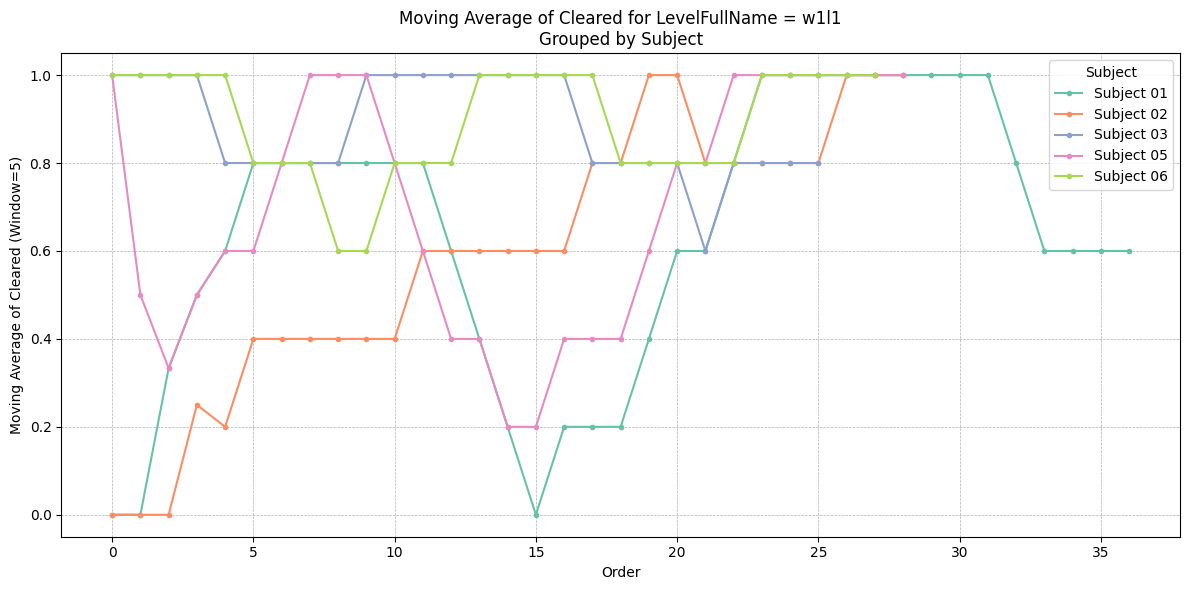

In [9]:
plot_moving_average_simple(
    df=repetitions_df,
    variable_col='Cleared',
    index_col='IndexGlobal',      # Use the exact column name from your repetitions_df
    grouping_col='Subject',
    filter_col='LevelFullName', # Use the exact column name
    filter_value='w1l1',
    window_size=5
)

In [12]:
subset_df = clips_df[clips_df['SceneFullName'] == 'w8l2s1']
subset_df


,Subject,World,Level,Duration,Cleared,ScoreGained,X_Traveled,Average_speed,Lives_lost,Hits_taken,...,EndFrame,TotalFrames,Bk2File,GameName,LevelFullName,SceneFullName,IndexInRun,IndexGlobal,IndexLevel,Phase
2472,01,8,2,2.350000,True,0,206,87.659574,0,0,...,334,2881,sub-01_ses-005_run-05_level-w8l2_scene-1_clip-...,SuperMarioBros-Nes,w8l2,w8l2s1,2,195,2,discovery
2488,01,8,2,7.116667,False,0,129,18.126464,1,1,...,627,2561,sub-01_ses-005_run-05_level-w8l2_scene-1_clip-...,SuperMarioBros-Nes,w8l2,w8l2s1,4,197,4,discovery
2507,01,8,2,2.383333,True,0,204,85.594406,0,0,...,1192,2881,sub-01_ses-005_run-05_level-w8l2_scene-1_clip-...,SuperMarioBros-Nes,w8l2,w8l2s1,2,195,2,discovery
2532,01,8,2,2.433333,True,0,206,84.657534,0,0,...,356,2682,sub-01_ses-005_run-05_level-w8l2_scene-1_clip-...,SuperMarioBros-Nes,w8l2,w8l2s1,7,200,7,discovery
2606,01,8,2,6.050000,False,0,151,24.958678,1,1,...,1891,1892,sub-01_ses-005_run-05_level-w8l2_scene-1_clip-...,SuperMarioBros-Nes,w8l2,w8l2s1,0,193,0,discovery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55737,06,8,2,8.583333,True,80,198,23.067961,0,0,...,2572,6729,sub-06_ses-025_run-05_level-w8l2_scene-1_clip-...,SuperMarioBros-Nes,w8l2,w8l2s1,2,608,27,practice
55746,06,8,2,8.450000,True,80,199,23.550296,0,0,...,721,9969,sub-06_ses-025_run-03_level-w8l2_scene-1_clip-...,SuperMarioBros-Nes,w8l2,w8l2s1,2,597,26,practice
55772,06,8,2,7.550000,True,0,199,26.357616,0,0,...,3626,6729,sub-06_ses-025_run-05_level-w8l2_scene-1_clip-...,SuperMarioBros-Nes,w8l2,w8l2s1,2,608,27,practice
55783,06,8,2,6.816667,True,0,201,29.486553,0,0,...,3070,9969,sub-06_ses-025_run-03_level-w8l2_scene-1_clip-...,SuperMarioBros-Nes,w8l2,w8l2s1,2,597,26,practice


<Axes: xlabel='ClipCode', ylabel='Cleared'>

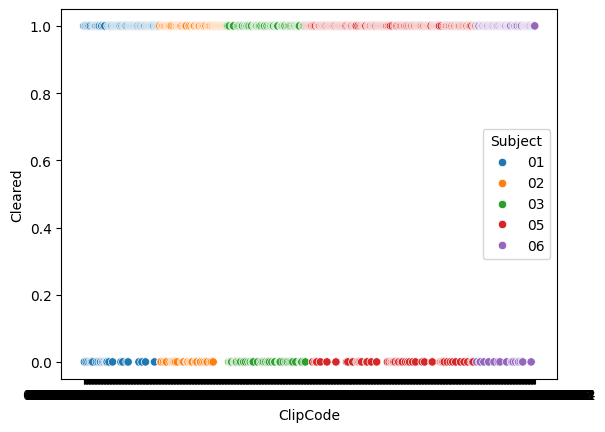

In [ ]:
import matplotlib.pyplot as plt



for subject in subset_df['Subject'].unique():
    plt.scatter()